# Main Preprocessing

# New Section

In [1]:
#Bayesian Optimiser using Optuna Library for XGBoost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.6 MB/s eta 0:00:00


In [18]:
# This is extracting data from the csv

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_parquet("conso_data_with_econ.parquet")

# 1. Handle missing values (Fill or Drop)
df.dropna(inplace=True)  # Remove missing values for simplicity

# Future Pricing calculation

In [19]:
#Data prep for future calculation - Still WIP

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Convert "month" (YYYY-MM) to datetime
df["transaction_date"] = pd.to_datetime(df["month"], format="%Y-%m")

# Sort to maintain chronological order
df = df.sort_values(by=["transaction_date","street_name"])
df = df.reset_index(drop=True)

# 4. Convert 'storey_range' to approximate floor level (take the median)
def storey_to_category(storey_range):
    ranges = storey_range.split(" TO ")
    median = (int(ranges[0]) + int(ranges[1])) / 2 if len(ranges) == 2 else int(ranges[0])

    if median <= 6:
        return 1
    elif 7 <= median <= 12:
        return 2
    else:
        return 3

df['storey_median'] = df['storey_range'].apply(storey_to_category)

# 5. Calculate the age of the flat
df['flat_age'] = (df['transaction_date'].dt.year - df['lease_commence_date']).astype('Int64')

# 6. One-hot encoding for categorical features
categorical_features = ['street_name', 'flat_type']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 7. Drop unnecessary columns
df.drop(['block', 'town', 'storey_range', 'remaining_lease','flat_model','month'], axis=1, inplace=True)

# 8. I want to print the data so far
df.head()

,floor_area_sqm,lease_commence_date,resale_price,cpi,gdp,unemployment,transaction_date,storey_median,flat_age,street_name_ADMIRALTY LINK,...,street_name_YUNG PING RD,street_name_YUNG SHENG RD,street_name_ZION RD,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,flat_type_MULTI-GENERATION
0,65.0,1975,34500.0,57.0,6.9,2.4,1992-06-01,2,17,False,...,False,False,False,False,True,False,False,False,False,False
1,76.0,1975,34000.0,57.0,6.9,2.4,1992-06-01,1,17,False,...,False,False,False,False,True,False,False,False,False,False
2,67.0,1978,55000.0,57.0,6.9,2.4,1992-06-01,1,14,False,...,False,False,False,False,True,False,False,False,False,False
3,121.0,1980,190000.0,57.0,6.9,2.4,1992-06-01,1,12,False,...,False,False,False,False,False,False,True,False,False,False
4,67.0,1977,50000.0,57.0,6.9,2.4,1992-06-01,1,15,False,...,False,False,False,False,True,False,False,False,False,False


In [20]:
#temporary testing
df["transaction_year"] = df["transaction_date"].dt.year
df["transaction_month"] = df["transaction_date"].dt.month
df.drop(['transaction_date'], axis=1, inplace=True)

# Define features and target
numerical_features = ['floor_area_sqm', 'storey_median', 'flat_age','cpi','unemployment','gdp']
scaler_future = StandardScaler()
df[numerical_features] = scaler_future.fit_transform(df[numerical_features])

df = df.reset_index(drop=True)
train_data = df[df["transaction_year"] < 2023]
test_data = df[df["transaction_year"] >= 2023]


#Numerical processing & splitting

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

X_train = train_data.drop(columns=['resale_price']) #added storey_median here so we can test how it performs without that
y_train = train_data['resale_price']
X_test = test_data.drop(columns=['resale_price'])
y_test = test_data['resale_price']

'''
#csv generation for sanity
df.to_csv("df.csv",index=False)
train_data.to_csv("train_data.csv",index=False)
test_data.to_csv("test_data.csv",index=False)
X_train.to_csv("X_train.csv",index=False)
y_train.to_csv("y_train.csv",index=False)
X_test.to_csv("X_test.csv",index=False)
y_test.to_csv("y_test.csv",index=False)
'''

df.head().to_csv('X_single_test_data_future.csv', index=False)
df.head()

,floor_area_sqm,lease_commence_date,resale_price,cpi,gdp,unemployment,storey_median,flat_age,street_name_ADMIRALTY LINK,street_name_AH HOOD RD,...,street_name_ZION RD,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,flat_type_MULTI-GENERATION,transaction_year,transaction_month
0,-1.206405,1975,34500.0,-1.344031,0.006497,-0.021917,0.478922,-0.120219,False,False,...,False,False,True,False,False,False,False,False,1992,6
1,-0.778743,1975,34000.0,-1.344031,0.006497,-0.021917,-0.977849,-0.120219,False,False,...,False,False,True,False,False,False,False,False,1992,6
2,-1.128648,1978,55000.0,-1.344031,0.006497,-0.021917,-0.977849,-0.394185,False,False,...,False,False,True,False,False,False,False,False,1992,6
3,0.970784,1980,190000.0,-1.344031,0.006497,-0.021917,-0.977849,-0.576829,False,False,...,False,False,False,False,True,False,False,False,1992,6
4,-1.128648,1977,50000.0,-1.344031,0.006497,-0.021917,-0.977849,-0.302863,False,False,...,False,False,True,False,False,False,False,False,1992,6


In [4]:
# Save the scaler
import pickle
with open('scaler_future.pkl', 'wb') as file:  # Open a file in write binary mode ('wb')
    pickle.dump(scaler_future, file)         # Dump the scaler object into the file

In [5]:
#Not needed, this is the first run without fine tuning
'''# Train XGBoost
model_future = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_future.fit(X_train, y_train.values.ravel())
xgb_pred = model_future.predict(X_test)

# Evaluate both models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

evaluate_model(y_test, xgb_pred, "XGBoost")


#sanity test
y_sanity = model_future.predict(X_train)
evaluate_model(y_train, y_sanity, "XGBoost")

#XGBoost - MAE: 73713.12, RMSE: 107973.81, R²: 0.6564
#XGBoost - MAE: 31637.43, RMSE: 45415.84, R²: 0.9168
'''

'# Train XGBoost\nmodel_future = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)\nmodel_future.fit(X_train, y_train.values.ravel())\nxgb_pred = model_future.predict(X_test)\n\n# Evaluate both models\ndef evaluate_model(y_true, y_pred, model_name):\n    mae = mean_absolute_error(y_true, y_pred)\n    rmse = np.sqrt(mean_squared_error(y_true, y_pred))\n    r2 = r2_score(y_true, y_pred)\n    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")\n\nevaluate_model(y_test, xgb_pred, "XGBoost")\n\n\n#sanity test\ny_sanity = model_future.predict(X_train)\nevaluate_model(y_train, y_sanity, "XGBoost")\n\n#XGBoost - MAE: 73713.12, RMSE: 107973.81, R²: 0.6564\n#XGBoost - MAE: 31637.43, RMSE: 45415.84, R²: 0.9168\n'

In [7]:
#Fine tuning XGBoost future pricing
#DO NOT RUN THIS CELL IT TAKES LIKE 90 MINS TO TEST ALL COMBINATION
'''
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 10)
    }

    xgb_model_tuned = XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    xgb_model_tuned.fit(X_train, y_train)
    y_pred = xgb_model_tuned.predict(X_test)
    return mean_squared_error(y_test, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

#Parameters printing
print("Best parameters:", study.best_trial.params)
'''

'\nimport optuna\n\ndef objective(trial):\n    params = {\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.3),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 500),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.3, 1),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 0.01, 10),\n        \'reg_alpha\': trial.suggest_loguniform(\'reg_alpha\', 0.01, 1),\n        \'reg_lambda\': trial.suggest_loguniform(\'reg_lambda\', 1, 10)\n    }\n\n    xgb_model_tuned = XGBRegressor(**params, objective="reg:squarederror", random_state=42)\n    xgb_model_tuned.fit(X_train, y_train)\n    y_pred = xgb_model_tuned.predict(X_test)\n    return mean_squared_error(y_test, y_pred)\n\n\nstudy = optuna.create_study(d

In [8]:
#Evaluation
#best_params = study.best_trial.params
final_model_future = XGBRegressor(max_depth=10, learning_rate=0.292951250437566, n_estimators=359, min_child_weight=10, subsample=0.7984707719554766, colsample_bytree=0.38561216417663424, gamma=0.3194904726766911, reg_alpha=0.40018263740984816, reg_lambda=2.198242875555133, objective="reg:squarederror", random_state=42)
final_model_future.fit(X_train, y_train)

y_pred = final_model_future.predict(X_test)
print(f"Final MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Final R2: {r2_score(y_test, y_pred)}")

#Final MSE: 4880974336.0
#Final R2: 0.8561643958091736

#Best parameters: {'max_depth': 10, 'learning_rate': 0.292951250437566, 'n_estimators': 359, 'min_child_weight': 10, 'subsample': 0.7984707719554766, 'colsample_bytree': 0.38561216417663424, 'gamma': 0.3194904726766911, 'reg_alpha': 0.40018263740984816, 'reg_lambda': 2.198242875555133}


Final MSE: 4880974336.0
Final R2: 0.8561643958091736


In [9]:
#choose the winner and pickle it
import pickle

output = open('final_model_future.pkl', 'wb')
pickle.dump(final_model_future, output)
output.close()

# Future pricing without economic model

In [10]:
#This is for comparison without economic data
'''
df = pd.read_parquet("conso_data_with_econ.parquet")

# Convert "month" (YYYY-MM) to datetime
df["transaction_date"] = pd.to_datetime(df["month"], format="%Y-%m")

# Sort to maintain chronological order
df = df.sort_values(by=["transaction_date","street_name"])
df = df.reset_index(drop=True)

# 4. Convert 'storey_range' to approximate floor level (take the median)
def storey_to_category(storey_range):
    ranges = storey_range.split(" TO ")
    median = (int(ranges[0]) + int(ranges[1])) / 2 if len(ranges) == 2 else int(ranges[0])

    if median <= 6:
        return 1
    elif 7 <= median <= 12:
        return 2
    else:
        return 3

df['storey_median'] = df['storey_range'].apply(storey_to_category)

# 5. Calculate the age of the flat
df['flat_age'] = (df['transaction_date'].dt.year - df['lease_commence_date']).astype('Int64')

# 6. One-hot encoding for categorical features
categorical_features = ['street_name', 'flat_type']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 7. Drop unnecessary columns
df.drop(['block', 'town', 'storey_range', 'remaining_lease','flat_model','month'], axis=1, inplace=True)

# 8. I want to print the data so far
df_noeconomic = df
df_noeconomic.drop(['cpi','gdp','unemployment'],axis=1,inplace=True)


df_noeconomic.head()
'''

'\ndf = pd.read_parquet("conso_data_with_econ.parquet")\n\n# Convert "month" (YYYY-MM) to datetime\ndf["transaction_date"] = pd.to_datetime(df["month"], format="%Y-%m")\n\n# Sort to maintain chronological order\ndf = df.sort_values(by=["transaction_date","street_name"])\ndf = df.reset_index(drop=True)\n\n# 4. Convert \'storey_range\' to approximate floor level (take the median)\ndef storey_to_category(storey_range):\n    ranges = storey_range.split(" TO ")\n    median = (int(ranges[0]) + int(ranges[1])) / 2 if len(ranges) == 2 else int(ranges[0])\n\n    if median <= 6:\n        return 1\n    elif 7 <= median <= 12:\n        return 2\n    else:\n        return 3\n\ndf[\'storey_median\'] = df[\'storey_range\'].apply(storey_to_category)\n\n# 5. Calculate the age of the flat\ndf[\'flat_age\'] = (df[\'transaction_date\'].dt.year - df[\'lease_commence_date\']).astype(\'Int64\')\n\n# 6. One-hot encoding for categorical features\ncategorical_features = [\'street_name\', \'flat_type\']\ndf = pd

In [11]:
#temporary testing
'''
df_noeconomic["transaction_year"] = df_noeconomic["transaction_date"].dt.year
df_noeconomic["transaction_month"] = df_noeconomic["transaction_date"].dt.month
df_noeconomic.drop(['transaction_date'], axis=1, inplace=True)

# Define features and target
numerical_features = ['floor_area_sqm', 'storey_median', 'flat_age']
scaler_future = StandardScaler()
df_noeconomic[numerical_features] = scaler_future.fit_transform(df_noeconomic[numerical_features])

df_noeconomic = df_noeconomic.reset_index(drop=True)
train_data = df_noeconomic[df_noeconomic["transaction_year"] < 2023]
test_data = df_noeconomic[df_noeconomic["transaction_year"] >= 2023]

#Numerical processing & splitting

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

X_train = train_data.drop(columns=['resale_price']) #added storey_median here so we can test how it performs without that
y_train = train_data['resale_price']
X_test = test_data.drop(columns=['resale_price'])
y_test = test_data['resale_price']

df_noeconomic.head()
'''

'\ndf_noeconomic["transaction_year"] = df_noeconomic["transaction_date"].dt.year\ndf_noeconomic["transaction_month"] = df_noeconomic["transaction_date"].dt.month\ndf_noeconomic.drop([\'transaction_date\'], axis=1, inplace=True)\n\n# Define features and target\nnumerical_features = [\'floor_area_sqm\', \'storey_median\', \'flat_age\']\nscaler_future = StandardScaler()\ndf_noeconomic[numerical_features] = scaler_future.fit_transform(df_noeconomic[numerical_features])\n\ndf_noeconomic = df_noeconomic.reset_index(drop=True)\ntrain_data = df_noeconomic[df_noeconomic["transaction_year"] < 2023]\ntest_data = df_noeconomic[df_noeconomic["transaction_year"] >= 2023]\n\n#Numerical processing & splitting\n\ntrain_data = train_data.reset_index(drop=True)\ntest_data = test_data.reset_index(drop=True)\n\nX_train = train_data.drop(columns=[\'resale_price\']) #added storey_median here so we can test how it performs without that\ny_train = train_data[\'resale_price\']\nX_test = test_data.drop(columns=[

In [12]:
'''
from xgboost import XGBRegressor


# Train XGBoost
model_future = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_future.fit(X_train, y_train.values.ravel())
xgb_pred = model_future.predict(X_test)

# Evaluate both models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

evaluate_model(y_test, xgb_pred, "XGBoost")


#sanity test
y_sanity = model_future.predict(X_train)
evaluate_model(y_train, y_sanity, "XGBoost")

#XGBoost - MAE: 76274.41, RMSE: 111377.99, R²: 0.6344 - real
#XGBoost - MAE: 32210.60, RMSE: 46011.61, R²: 0.9146 - sanity
'''

'\nfrom xgboost import XGBRegressor\n\n\n# Train XGBoost\nmodel_future = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)\nmodel_future.fit(X_train, y_train.values.ravel())\nxgb_pred = model_future.predict(X_test)\n\n# Evaluate both models\ndef evaluate_model(y_true, y_pred, model_name):\n    mae = mean_absolute_error(y_true, y_pred)\n    rmse = np.sqrt(mean_squared_error(y_true, y_pred))\n    r2 = r2_score(y_true, y_pred)\n    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")\n\nevaluate_model(y_test, xgb_pred, "XGBoost")\n\n\n#sanity test\ny_sanity = model_future.predict(X_train)\nevaluate_model(y_train, y_sanity, "XGBoost")\n\n#XGBoost - MAE: 76274.41, RMSE: 111377.99, R²: 0.6344 - real\n#XGBoost - MAE: 32210.60, RMSE: 46011.61, R²: 0.9146 - sanity\n'

In [13]:
'''
#Fine tuning XGBoost future pricing
#DO NOT RUN THIS CELL IT TAKES LIKE 90 MINS TO TEST ALL COMBINATION

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

#Parameters printing
print("Best parameters:", study.best_trial.params)
'''

'\n#Fine tuning XGBoost future pricing\n#DO NOT RUN THIS CELL IT TAKES LIKE 90 MINS TO TEST ALL COMBINATION\n\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=20)\n\n#Parameters printing\nprint("Best parameters:", study.best_trial.params)\n'

In [14]:
#Evaluation
'''
best_params = study.best_trial.params
final_model_future = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
final_model_future.fit(X_train, y_train)

y_pred = final_model_future.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Final MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Final R2: {r2_score(y_test, y_pred)}")
'''
#Final MSE: 6433383424.0
#Final R2: 0.8104169964790344

'\nbest_params = study.best_trial.params\nfinal_model_future = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)\nfinal_model_future.fit(X_train, y_train)\n\ny_pred = final_model_future.predict(X_test)\nr2 = r2_score(y_test, y_pred)\nprint(f"Final MSE: {mean_squared_error(y_test, y_pred)}")\nprint(f"Final R2: {r2_score(y_test, y_pred)}")\n'

# Testing and Others

In [15]:
#Only run this when you want to test, upload the test file
'''
import pandas as pd
import pickle

# 1. Load the scaler and model
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
with open('final_model.pkl', 'rb') as file:
    model = pickle.load(file)

# 2. Read X_single_test_data from CSV
X_single_test = pd.read_csv("X_single_test_data.csv")  # Replace with your CSV filename

# 3. Select numerical features for scaling
numerical_features = ['floor_area_sqm', 'storey_median', 'flat_age']

# 4. Scale the numerical features
X_single_test[numerical_features] = scaler.transform(X_single_test[numerical_features])

# 5. Make prediction
predicted_price = model.predict(X_single_test)
print(f"Predicted Price: {predicted_price}")
'''

'\nimport pandas as pd\nimport pickle\n\n# 1. Load the scaler and model\nwith open(\'scaler.pkl\', \'rb\') as file:\n    scaler = pickle.load(file)\nwith open(\'final_model.pkl\', \'rb\') as file:\n    model = pickle.load(file)\n\n# 2. Read X_single_test_data from CSV\nX_single_test = pd.read_csv("X_single_test_data.csv")  # Replace with your CSV filename\n\n# 3. Select numerical features for scaling\nnumerical_features = [\'floor_area_sqm\', \'storey_median\', \'flat_age\']\n\n# 4. Scale the numerical features\nX_single_test[numerical_features] = scaler.transform(X_single_test[numerical_features])\n\n# 5. Make prediction\npredicted_price = model.predict(X_single_test)\nprint(f"Predicted Price: {predicted_price}")\n'

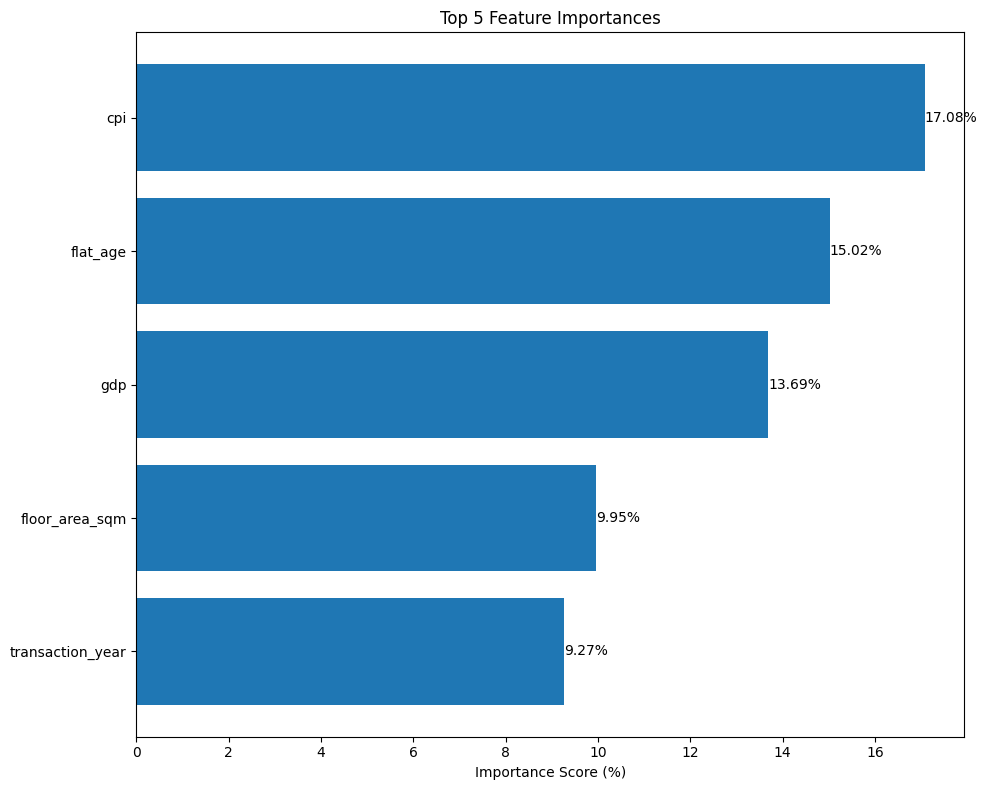

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np #import numpy for percentage calculation

# Get feature importance scores as a dictionary
importance = final_model_future.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame for easier plotting and sorting
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# ... (previous code) ...

# Instead of excluding 'year' and 'month', sum their importances
month_year_importance = importance_df.loc[importance_df['Feature'].isin(['year', 'month']), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(['year', 'month'])]
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['month_year'], 'Importance': [month_year_importance]})], ignore_index=True)

# ... (rest of the code) ...

# Group flat types and sum importance
flat_type_features = [col for col in importance_df['Feature'] if 'flat_type_' in col]
flat_type_importance = importance_df.loc[importance_df['Feature'].isin(flat_type_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(flat_type_features)]  # Remove individual flat type features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['flat_type'], 'Importance': [flat_type_importance]})] , ignore_index=True)

# Group street names and sum importance
street_name_features = [col for col in importance_df['Feature'] if 'street_name_' in col]
street_name_importance = importance_df.loc[importance_df['Feature'].isin(street_name_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(street_name_features)]  # Remove individual street name features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['street_name'], 'Importance': [street_name_importance]})] , ignore_index=True)

# Combine flat_age and lease_commence_date into flat_age
age_features = ['flat_age', 'lease_commence_date']
combined_age_importance = importance_df.loc[importance_df['Feature'].isin(age_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(age_features)] # Remove individual age features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['flat_age'], 'Importance': [combined_age_importance]})] , ignore_index=True)


# Calculate percentage importance
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top features with percentages
top_n = 5
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])

# Add percentages next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', ha='left', va='center')

plt.xlabel('Importance Score (%)')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()